# Step 2: Pre-processing - Resampling 🌐

The goal is to produce a **250 x 250m grid** of the **probability of presence** of **Zosteraceae**. However, my input datasets have different resolutions. Specifically, I have three types of datasets:

- **`filtered_Artportalen-Zosteraceae.csv`**: A **point dataset**.
- **`filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc`**, **`yearly_mean_CMEMS_BAL_WAV_MY_2015.nc`**, and **`filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc`**: Datasets with a **2km x 2km resolution**.
- **`filtered_bathymetry`**: A dataset with **115m x 115m resolution**.

Additionally, I need to ensure that all datasets—both **point** and **raster**—align perfectly on the same **250m x 250m grid**. To achieve this, I will apply a consistent **transformation and resampling** process.

For guidance on these steps, I referred to the [Copernicus Marine documentation](https://help.marine.copernicus.eu/en/articles/7924877-how-to-reduce-or-increase-the-spatial-grid-resolution-of-a-dataset-in-python). However, I did not use this documentation directly because it primarily works with **degrees** as the unit of measurement, whereas I needed to work with **meters**.

#### 📚 Required Libraries
To perform the resampling and transformation, I need the following libraries:
- **`geopandas`**: For working with geometries.
- **`numpy`**: For numerical operations and resampling.
- **`pandas`**: For reading, manipulating, and analyzing the data.
- **`shapely`**: For working with bounding boxes and creating grids.
- **`xarray`**: To open and manipulate the downloaded datasets.
- **`rasterstats`**: For resampling raster data.
- **`affine`**: For defining the resampling function for rasters.

### 🛠️ Steps:
1. **Generate the Grid**: 
   - Using the **Living Lab West geometry**, I created a **250m x 250m grid** to match the desired resolution.

2. **Resample the Bathymetry Data**: 
   - Using the `zonal_stats` function from the `rasterstats` library, I calculated the mean for the defined pixels of the **bathymetry TIF** dataset.

3. **Resample the Copernicus Marine Datasets**: 
   - Similarly, I applied **`zonal_stats`** to resample the **Copernicus Marine datasets** (with array data). By defining the required transformation, I ensured the datasets were resampled to the **250m x 250m grid**.



______

## 🛠️ Generating the Grid

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from shapely.geometry import box

The geometry of my region is reprojected into a projected CRS `EPSG:32633` to make sure distances are measured in meters, which is essential for my grid calculations. I will create a 250 x 250m grid.

In [2]:
# Load the Living Lab West geometry
livinglab_west = gpd.read_file("data/livinglab_west.json")

# Reproject the geometry to a projected CRS
livinglab_west = livinglab_west.to_crs(epsg=32633)

# Define the grid resolution (250m by 250m)
grid_resolution = 250

# Get the bounds of the Living Lab West region
minx, miny, maxx, maxy = livinglab_west.total_bounds

In [3]:
# Create a grid of 250x250m within the bounds of the Living Lab West
grid_cells = []
for x in np.arange(minx, maxx, grid_resolution):
    for y in np.arange(miny, maxy, grid_resolution):
        grid_cells.append(Polygon([(x, y),
                                   (x + grid_resolution, y),
                                   (x + grid_resolution, y + grid_resolution),
                                   (x, y + grid_resolution)]))
        
# Create a GeoDataFrame for the grid with the same CRS as the Living Lab West region
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=livinglab_west.crs)

I used Spatial Indexing to Speed Up Clipping. `Geopandas` allows for spatial indexing with rtree (a library for spatial indexing), which can speed up operations like clipping or spatial joins.

In [4]:
# Create a spatial index for the region geometry
from rtree import index

# Create an R-tree spatial index for the Living Lab West geometry
idx = index.Index()

# Add the geometries of the Living Lab West region to the index
for i, geometry in enumerate(livinglab_west.geometry):
    # Only use the exterior of the polygon (ignoring the holes)
    idx.insert(i, geometry.exterior.bounds)

# Filter grid cells that intersect with the region geometry using the index
grid_cells_clipped = []
for cell in grid.geometry:
    # Use the exterior of the grid cell to check for intersections
    if any(livinglab_west.geometry.intersects(cell)):
        grid_cells_clipped.append(cell)


In [7]:
# Save the clipped grid cells to a GeoDataFrame
clipped_grid = gpd.GeoDataFrame({'geometry': grid_cells_clipped}, crs=livinglab_west.crs)
# Save the clipped grid to a file
clipped_grid.to_file("data/clipped_grid_32633.geojson", driver='GeoJSON')

To visualize the resulte, I opened the clipped_grid in QGIS as a vector layer.

## 🛠️ Resampling the Bathymetry Data

In [8]:
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import rasterstats as rs

Because my dataset is quite large, I need to use GeoTIFF format rather than numpy array. When I dowloaded my raster, I have to be carfull to the CRS.

In [9]:
# Load the data
bathymetry_raster = "data/D5_2024.tif" 
raster_crs = "EPSG:4326"  # Coordinate Reference System of the raster
clipped_grid_32633 = gpd.read_file("data/clipped_grid_32633.geojson")

In [12]:
# Reproject the grid if necessary
clipped_grid_4326 = clipped_grid_32633.to_crs(raster_crs)  # Align with the CRS of the raster
# Save the reprojected grid to a file
clipped_grid_4326.to_file("data/clipped_grid_4326.geojson", driver='GeoJSON')

In [13]:
# Perform zonal statistics: calculate the mean of the bathymetry values within each grid cell
zonal_stats = rs.zonal_stats(clipped_grid_4326, bathymetry_raster, stats="mean")

In [14]:
# Convert the zonal stats results to a DataFrame for easier manipulation
zonal_stats_df = pd.DataFrame(zonal_stats)

# Check the first few rows of the zonal stats DataFrame
print(zonal_stats_df.head())

         mean
0 -459.075317
1 -462.190002
2 -466.197754
3 -471.135791
4 -475.315869


In [15]:
# Add the mean bathymetry values to your grid GeoDataFrame
clipped_grid_4326['mean_bathymetry'] = zonal_stats_df['mean']

# Check the updated grid with mean bathymetry values
print(clipped_grid_4326.head())

                                            geometry  mean_bathymetry
0  POLYGON ((10.03035 58.25918, 10.03459 58.25935...      -459.075317
1  POLYGON ((10.03003 58.26142, 10.03428 58.26158...      -462.190002
2  POLYGON ((10.02972 58.26365, 10.03396 58.26382...      -466.197754
3  POLYGON ((10.0294 58.26589, 10.03365 58.26606,...      -471.135791
4  POLYGON ((10.02909 58.26813, 10.03333 58.26829...      -475.315869


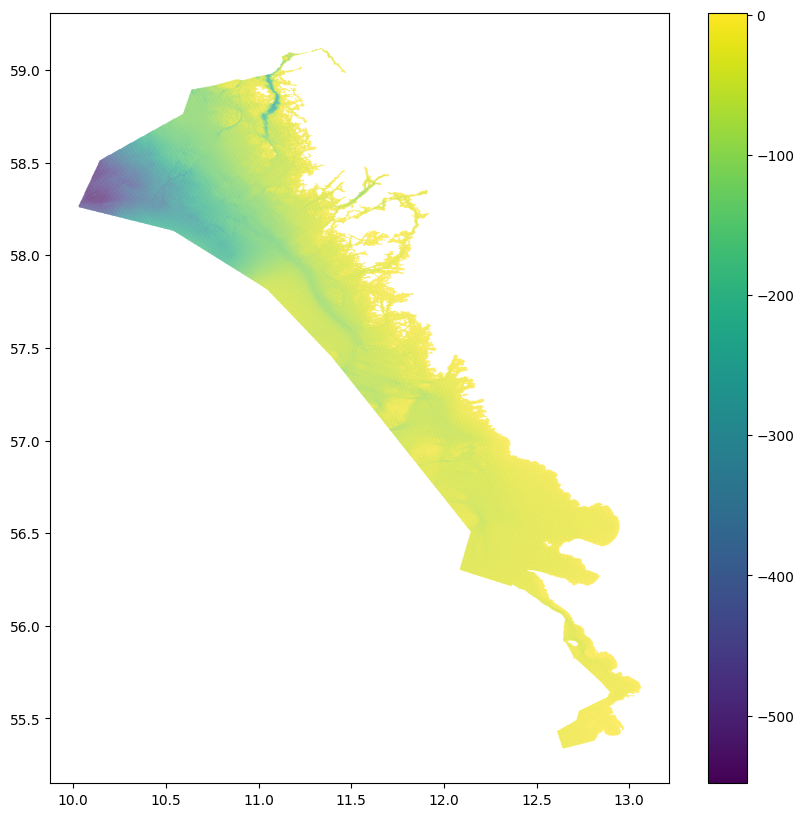

In [16]:
import matplotlib.pyplot as plt

# Plot the grid with the resampled bathymetry values (mean bathymetry per grid cell)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid with the mean bathymetry values
clipped_grid_4326.plot(ax=ax, column='mean_bathymetry', cmap='viridis', legend=True, edgecolor='none', linewidth=0)

# Set aspect ratio to equal to avoid distortion
ax.set_aspect('equal')

# Show the plot
plt.show()

In [17]:
# Extract the centroid coordinates of each cell
clipped_grid_4326['centroid'] = clipped_grid_4326.geometry.centroid
longitude = clipped_grid_4326['centroid'].x.values  # Extract longitude from centroid
latitude = clipped_grid_4326['centroid'].y.values   # Extract latitude from centroid

# Extract the mean bathymetry values
mean_bathymetry_values = clipped_grid_4326['mean_bathymetry'].values

# Create an xarray DataArray with the spatial coordinates and mean bathymetry values
data_array = xr.DataArray(
    mean_bathymetry_values, 
    dims=["grid_cell"],
    coords={"grid_cell": range(len(clipped_grid_4326))},  # Coordinate based on the grid cell index
    name="mean_bathymetry"
)

# Create an xarray Dataset (you can add more variables here if needed)
dataset = xr.Dataset({
    "mean_bathymetry": data_array
})

C:\Users\PC\AppData\Local\Temp\ipykernel_17080\1672228019.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clipped_grid_4326['centroid'] = clipped_grid_4326.geometry.centroid


In [18]:
# Save the dataset to a NetCDF file
output_nc = "data/00_environmental_variables.nc"
dataset.to_netcdf(output_nc)

In [19]:
ds = xr.open_dataset(output_nc)
ds

<xarray.Dataset> Size: 3MB
Dimensions:          (grid_cell: 240356)
Coordinates:
  * grid_cell        (grid_cell) int32 961kB 0 1 2 3 ... 240353 240354 240355
Data variables:
    mean_bathymetry  (grid_cell) float64 2MB ...

## 🛠️ Resampling the Copernicus Marine datasets

In [20]:
import geopandas as gpd
import rasterstats as rs
import numpy as np
from affine import Affine
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
ds = xr.open_dataset('data/BAL-MYP-ERGOM_BGC-AnnualMeans-2023.nc')
raster_crs = "EPSG:4326"
clipped_grid_4326 = gpd.read_file("data/clipped_grid_4326.geojson")
ds

<xarray.Dataset> Size: 933MB
Dimensions:  (time: 1, depth: 56, lat: 774, lon: 763)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2023-07-01T06:00:00
Data variables:
    chl      (time, depth, lat, lon) float32 132MB ...
    nh4      (time, depth, lat, lon) float32 132MB ...
    no3      (time, depth, lat, lon) float32 132MB ...
    nppv     (time, depth, lat, lon) float32 132MB ...
    o2       (time, depth, lat, lon) float32 132MB ...
    o2b      (time, lat, lon) float32 2MB ...
    ph       (time, depth, lat, lon) float32 132MB ...
    po4      (time, depth, lat, lon) float32 132MB ...
    spco2    (time, lat, lon) float32 2MB ...
    zsd      (time, lat, lon) float32 2MB ...
Attributes: (12/22)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Sun Nov 10 12:03:11 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2023-01-01 12:00:00
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS ERGOM annual integrated model fields

As I am working on Zosteraceae, and focusing on the surface level for presence modeling, I will just use the first depth layer of the chlorophyll dataset.

In [26]:
# Extract the relevant variable
chl = ds["chl"].values

# Select the surface layer (depth=0)
chl_surface = chl[0,0, :, :] 
chl_surface.shape

(774, 763)

Because we are not woring with a TIF file but with an array we have to define the the affine transform.

In [27]:
# Extract coordinates first
lon = ds.lon.values
lat = ds.lat.values

# Ensure data and coordinates are properly aligned
# Flip latitude array if needed (should go from high to low)
if lat[0] < lat[-1]:
    lat = lat[::-1]
    chl_surface = chl_surface[::-1, :]

# Calculate correct pixel sizes
pixel_width = (lon[-1] - lon[0]) / (len(lon) - 1)
pixel_height = (lat[0] - lat[-1]) / (len(lat) - 1)  # Note: positive value

# Create the affine transform with correct orientation
transform = Affine(
    pixel_width,        # a: width of a pixel
    0,                  # b: row rotation (usually 0)
    lon[0],            # c: x-coordinate of upper left corner of upper left pixel
    0,                 # d: column rotation (usually 0)
    -pixel_height,     # e: negative height of a pixel
    lat[0]             # f: y-coordinate of upper left corner of upper left pixel
)

In [28]:
# Now try the zonal statistics
zonal_stats_result = rs.zonal_stats(
    vectors=clipped_grid_4326,
    raster=chl_surface,
    stats="mean",
    affine=transform,
    nodata=np.nan,
    all_touched=True
)


Zonal stats summary:
count    232552.000000
mean          1.409350
std           0.288973
min           0.435349
25%           1.257346
50%           1.303783
75%           1.469208
max           4.081560
Name: mean, dtype: float64


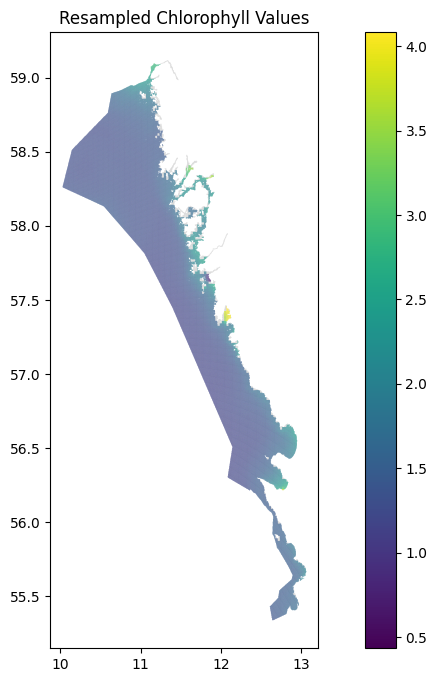

In [29]:
# Check results
zonal_stats_df = pd.DataFrame(zonal_stats_result)
print("\nZonal stats summary:")
print(zonal_stats_df['mean'].describe())

# Add to grid and visualize
clipped_grid_4326['chl_surface'] = zonal_stats_df['mean']

# Plot to verify
fig, ax = plt.subplots(figsize=(12, 8))
clipped_grid_4326.plot(column='chl_surface', 
                      cmap='viridis',
                      legend=True,
                      missing_kwds={'color': 'lightgrey'},
                      ax=ax)
ax.set_title('Resampled Chlorophyll Values')
plt.show()

This is the result intended.

Let's repeat the process for each variable I need by coding a function.

In [30]:
def resample_variable(variable_name, ds, clipped_grid_4326, transform, flip_var):
    """
    Resample a variable from the dataset to the grid defined in clipped_grid_4326.
    
    Args:
        variable_name (str): Name of the variable to resample.
        year (int): Year for which the data is being processed.
        ds (xarray.Dataset): The dataset containing the variable.
        clipped_grid_4326 (geopandas.GeoDataFrame): The grid to which the variable will be resampled.
        dim_depth (bool): Whether the variable has a depth dimension.
        transform (Affine): Affine transformation for the raster data.
    
    Returns:
        xarray.DataArray: Resampled data array.
    """
    # Extract the variable
    var_data = ds[variable_name].values
    
    
    try:
        # Handle variables with time and/or depth dimensions
        shape = var_data.shape
        if var_data.ndim == 4:
            # Find axes for time, depth, lat, lon by matching shape to ds.dims
            dims = list(ds[variable_name].dims)
            # Select first time and first depth slice, regardless of axis order
            time_axis = dims.index('time') if 'time' in dims else None
            depth_axis = dims.index('depth') if 'depth' in dims else None
            lat_axis = dims.index('lat')
            lon_axis = dims.index('lon')
            # Use np.take to select first time and depth slice
            idx = [0 if i == time_axis or i == depth_axis else slice(None) for i in range(4)]
            var_data = var_data[tuple(idx)]
        elif var_data.ndim == 3:
            dims = list(ds[variable_name].dims)
            # If both time and lat/lon, select first time slice
            if 'time' in dims:
                time_axis = dims.index('time')
                idx = [0 if i == time_axis else slice(None) for i in range(3)]
                var_data = var_data[tuple(idx)]
            elif 'depth' in dims:
                depth_axis = dims.index('depth')
                idx = [0 if i == depth_axis else slice(None) for i in range(3)]
                var_data = var_data[tuple(idx)]
            # else already (lat, lon)
        elif var_data.ndim == 2:
            pass  # Already (lat, lon)
        else:
            print(f"Unexpected shape for variable '{variable_name}': {var_data.shape}")
            return None
        var_data = var_data[::-1, :] if flip_var else var_data
    except Exception as e:
        print(f"Error extracting variable '{variable_name}': {e}")
        return None

    # Perform zonal statistics
    zonal_stats_result = rs.zonal_stats(
        vectors=clipped_grid_4326,
        raster=var_data,
        stats="mean",
        affine=transform,
        nodata=np.nan,
        all_touched=True
    )
    
    # Convert results to DataFrame
    zonal_stats_df = pd.DataFrame(zonal_stats_result)
    
    # Add to grid
    clipped_grid_4326[variable_name] = zonal_stats_df['mean']
    
    return clipped_grid_4326[variable_name]

In [31]:
ds_BGC = xr.open_dataset(f"data/BAL-MYP-ERGOM_BGC-AnnualMeans-2023.nc")
ds_PHY = xr.open_dataset(f"data/BAL-MYP-NEMO_PHY-AnnualMeans-2023.nc")
ds_WAV = xr.open_dataset(f"data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.nc")   
clipped_grid_4326 = gpd.read_file("data/clipped_grid_4326.geojson")

In `ds_BGC`, I will resample `'chl','no3','nppv','o2','ph','po4'`and `'zsd'`. 

In [32]:
var_list_BGC = ['chl','no3','nppv','o2','ph','po4','zsd']
ds_BGC

<xarray.Dataset> Size: 933MB
Dimensions:  (time: 1, depth: 56, lat: 774, lon: 763)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2023-07-01T06:00:00
Data variables:
    chl      (time, depth, lat, lon) float32 132MB ...
    nh4      (time, depth, lat, lon) float32 132MB ...
    no3      (time, depth, lat, lon) float32 132MB ...
    nppv     (time, depth, lat, lon) float32 132MB ...
    o2       (time, depth, lat, lon) float32 132MB ...
    o2b      (time, lat, lon) float32 2MB ...
    ph       (time, depth, lat, lon) float32 132MB ...
    po4      (time, depth, lat, lon) float32 132MB ...
    spco2    (time, lat, lon) float32 2MB ...
    zsd      (time, lat, lon) float32 2MB ...
Attributes: (12/22)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Sun Nov 10 12:03:11 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2023-01-01 12:00:00
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS ERGOM annual integrated model fields

 In `ds_PHY`, I will resample `'bottomT','siconc','sithick','sla','so','sob','thetao','uo'`and `'vo'`.  In `ds_WAV`, I will resample `'VHM0','VTPK','VHM0_SW2','VTM01_SW2','VSDX','VSDY','VMXL'`and `'VCMX'`.

In [33]:
var_list_PHY = ['bottomT','siconc','sithick','sla','so','sob','thetao','uo','vo']
var_list_WAV = ['VHM0','VTPK','VHM0_SW2','VTM01_SW2','VSDX','VSDY','VMXL','VCMX']
ds_PHY

<xarray.Dataset> Size: 543MB
Dimensions:  (time: 1, lat: 774, lon: 763, depth: 56)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2023-07-01T06:00:00
Data variables:
    bottomT  (time, lat, lon) float32 2MB ...
    mlotst   (time, lat, lon) float32 2MB ...
    siconc   (time, lat, lon) float32 2MB ...
    sithick  (time, lat, lon) float32 2MB ...
    sla      (time, lat, lon) float32 2MB ...
    so       (time, depth, lat, lon) float32 132MB ...
    sob      (time, lat, lon) float32 2MB ...
    thetao   (time, depth, lat, lon) float32 132MB ...
    uo       (time, depth, lat, lon) float32 132MB ...
    vo       (time, depth, lat, lon) float32 132MB ...
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Tue Jun 25 17:31:21 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    northernmost_latitude:  65.89099
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2023-01-01 12:00:00
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS NEMO annual integrated model fields

⏳ The next step is veeery long. 

Variable chl already exists in the grid. Skipping resampling.
Variable no3 already exists in the grid. Skipping resampling.
Variable nppv already exists in the grid. Skipping resampling.
Variable o2 already exists in the grid. Skipping resampling.
Variable ph already exists in the grid. Skipping resampling.
Variable po4 already exists in the grid. Skipping resampling.
Variable zsd already exists in the grid. Skipping resampling.
Variable bottomT already exists in the grid. Skipping resampling.
Variable siconc already exists in the grid. Skipping resampling.
Variable sithick already exists in the grid. Skipping resampling.
Variable sla already exists in the grid. Skipping resampling.
Variable so already exists in the grid. Skipping resampling.
Variable sob already exists in the grid. Skipping resampling.
Variable thetao already exists in the grid. Skipping resampling.
Variable uo already exists in the grid. Skipping resampling.
Variable vo already exists in the grid. Skipping resampling

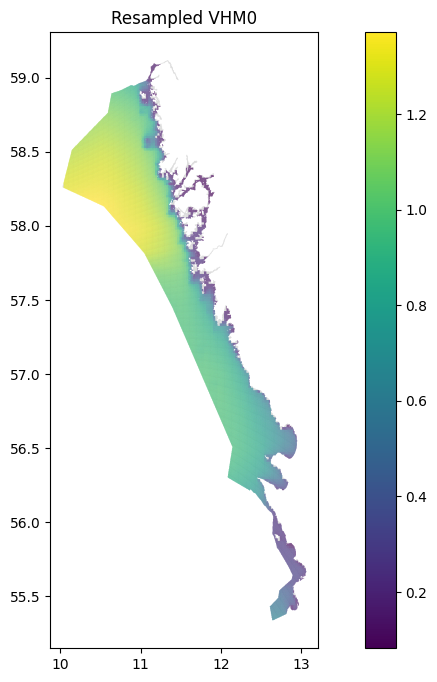

Resampled VTPK for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


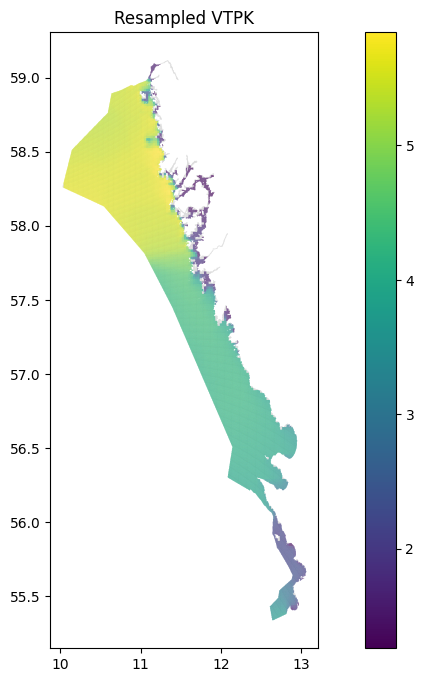

Resampled VHM0_SW2 for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


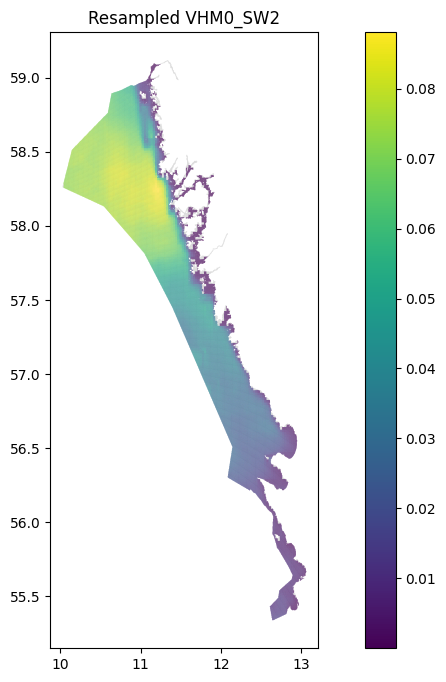

Resampled VTM01_SW2 for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


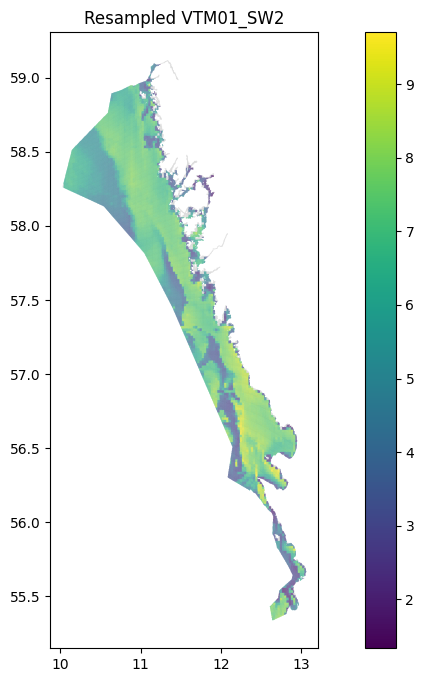

Resampled VSDX for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


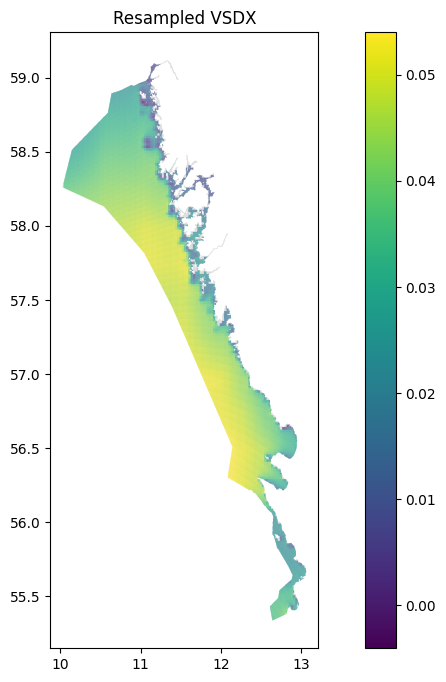

Resampled VSDY for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


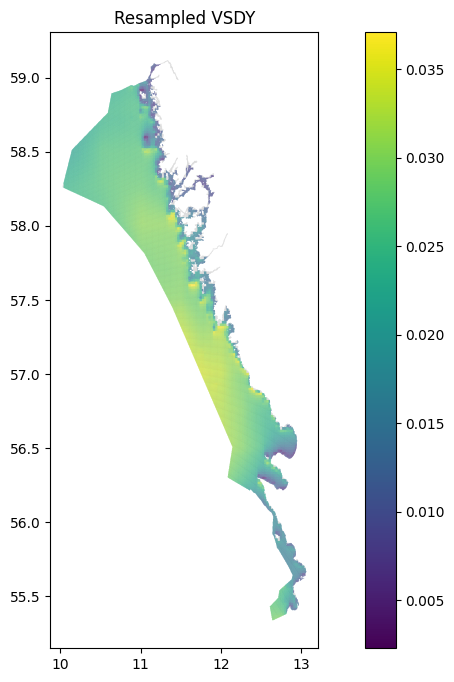

Resampled VMXL for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


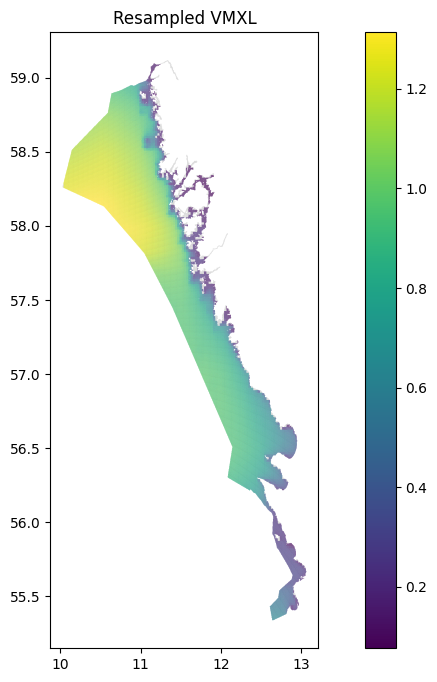

Resampled VCMX for data/CMEMS_BAL_WAV_MY-AnnualMeans-2023.


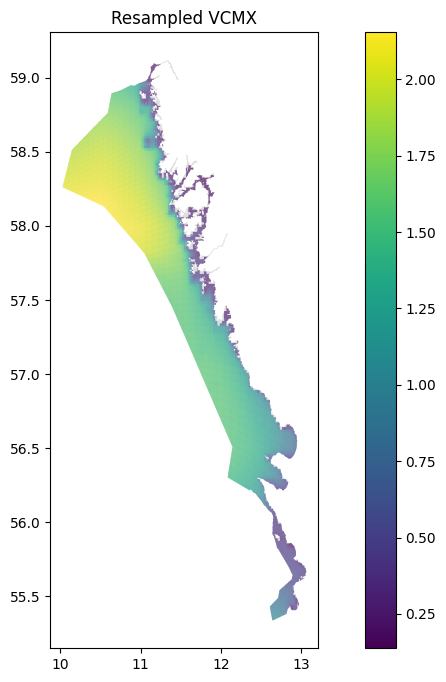

In [35]:
dataset_name_dic = {'data/BAL-MYP-ERGOM_BGC-AnnualMeans-2023':var_list_BGC,
                    'data/BAL-MYP-NEMO_PHY-AnnualMeans-2023':var_list_PHY,
                    'data/CMEMS_BAL_WAV_MY-AnnualMeans-2023':var_list_WAV}

for ds_name in dataset_name_dic.keys():
    var_list = dataset_name_dic[ds_name]

    ds = xr.open_dataset(f'{ds_name}.nc')

    lon = ds.lon.values
    lat = ds.lat.values

    # Flip latitude if needed so it goes from high to low
    if lat[0] < lat[-1]:
        lat = lat[::-1]
        flip_var = True
        # For each variable, I flip the data array if needed inside the resample_variable function
        # Here, just note that lat is flipped for affine calculation and zonal stats

    pixel_width = (lon[-1] - lon[0]) / (len(lon) - 1)
    pixel_height = (lat[0] - lat[-1]) / (len(lat) - 1)  # Note: positive value
        
    transform = Affine(
        pixel_width,        
        0,               
        lon[0],           
        0,             
        -pixel_height,    
        lat[0]            
    )

    for variable_name in var_list:
        if variable_name in clipped_grid_4326.columns:
            print(f"Variable {variable_name} already exists in the grid. Skipping resampling.")
            continue
        resampled_var = resample_variable(variable_name, ds, clipped_grid_4326, transform, flip_var)
        print(f"Resampled {variable_name} for {ds_name}.")


        # Plot to verify
        fig, ax = plt.subplots(figsize=(12, 8))
        clipped_grid_4326.plot(column=variable_name, 
                            cmap='viridis',
                            legend=True,
                            missing_kwds={'color': 'lightgrey'},
                            ax=ax)
        ax.set_title(f'Resampled {variable_name}')
        plt.show()
    



In [36]:
clipped_grid_4326

,geometry,chl,no3,nppv,o2,ph,po4,zsd,bottomT,siconc,...,uo,vo,VHM0,VTPK,VHM0_SW2,VTM01_SW2,VSDX,VSDY,VMXL,VCMX
0,"POLYGON ((10.03035 58.25918, 10.03459 58.25935...",1.315495,1.586457,2388.953857,289.098206,8.212018,0.452668,13.304657,6.310916,0.0,...,0.054501,0.065077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((10.03003 58.26142, 10.03428 58.26158...",1.315495,1.586457,2388.953857,289.098206,8.212018,0.452668,13.304657,6.310916,0.0,...,0.054501,0.065077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((10.02972 58.26365, 10.03396 58.26382...",1.315495,1.586457,2388.953857,289.098206,8.212018,0.452668,13.304657,6.310916,0.0,...,0.054501,0.065077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((10.0294 58.26589, 10.03365 58.26606,...",1.315495,1.586457,2388.953857,289.098206,8.212018,0.452668,13.304657,6.310916,0.0,...,0.054501,0.065077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((10.02909 58.26813, 10.03333 58.26829...",1.315495,1.586457,2388.953857,289.098206,8.212018,0.452668,13.304657,6.310916,0.0,...,0.054501,0.065077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240351,"POLYGON ((13.05616 55.68358, 13.06013 55.68364...",2.017805,4.840452,5646.053711,335.755066,8.171505,0.337169,8.854092,11.165191,0.0,...,-0.006674,0.015324,0.214206,2.066993,0.002324,2.790750,0.024698,0.016682,0.214038,0.353075
240352,"POLYGON ((13.06113 55.66344, 13.0651 55.6635, ...",1.999801,4.590124,5881.569824,335.344910,8.169117,0.341800,8.900568,11.199465,0.0,...,0.010994,0.012605,0.235098,2.070427,0.002749,3.482053,0.027726,0.013170,0.232769,0.389363
240353,"POLYGON ((13.06102 55.66568, 13.06499 55.66575...",1.999801,4.590124,5881.569824,335.344910,8.169117,0.341800,8.900568,11.199465,0.0,...,0.010994,0.012605,0.235098,2.070427,0.002749,3.482053,0.027726,0.013170,0.232769,0.389363
240354,"POLYGON ((13.06091 55.66793, 13.06488 55.66799...",1.999801,4.590124,5881.569824,335.344910,8.169117,0.341800,8.900568,11.199465,0.0,...,0.010994,0.012605,0.235098,2.070427,0.002749,3.482053,0.027726,0.013170,0.232769,0.389363


The clipped grid count now 25 columns ! However, we can remarque that there is NaN values in some columns. If can be an issue if they correspond to cells with Zosteraceae presence because the MaxEnt model used in the next steps doesn't allow NaN values. That's why I will delete these rows after.

In [37]:
# Count the number of NaN values in each variable
for variable in clipped_grid_4326.columns:
    if variable != 'geometry':  # Skip geometry column
        nan_count = clipped_grid_4326[variable].isna().sum()
        print(f"Variable '{variable}': {nan_count} NaN values")


Variable 'chl': 7804 NaN values
Variable 'no3': 7804 NaN values
Variable 'nppv': 7804 NaN values
Variable 'o2': 7804 NaN values
Variable 'ph': 7804 NaN values
Variable 'po4': 7804 NaN values
Variable 'zsd': 7804 NaN values
Variable 'bottomT': 7804 NaN values
Variable 'siconc': 7804 NaN values
Variable 'sithick': 7804 NaN values
Variable 'sla': 7804 NaN values
Variable 'so': 7804 NaN values
Variable 'sob': 7804 NaN values
Variable 'thetao': 7804 NaN values
Variable 'uo': 7804 NaN values
Variable 'vo': 7804 NaN values
Variable 'VHM0': 7810 NaN values
Variable 'VTPK': 7810 NaN values
Variable 'VHM0_SW2': 7810 NaN values
Variable 'VTM01_SW2': 7810 NaN values
Variable 'VSDX': 7810 NaN values
Variable 'VSDY': 7810 NaN values
Variable 'VMXL': 7810 NaN values
Variable 'VCMX': 7810 NaN values


In [38]:
# Save the updated grid with all resampled variables to a new GeoJSON file
output_geojson = "data/clipped_grid_4326_resampled.geojson"
clipped_grid_4326.to_file(output_geojson, driver='GeoJSON')